# ezlocalai Tests and Examples

Simply choose your favorite model of choice from the models list and paste it into the `model` variable on the API calls. You can get a list of models below.

Install OpenAI and requests:

```bash
pip install openai requests python-dotenv
```

**Note, you do not need an OpenAI API Key, the API Key is your `EZLOCALAI_API_KEY` for the server if you defined one in your `.env` file.**

## Global definitions and helpers

Confirm that your `DEFAULT_MODEL` is set to the model you want to use in your `.env` file.


In [46]:
import openai
import requests
import time
import os
import re
from dotenv import load_dotenv

load_dotenv()

# Set your system message, max tokens, temperature, and top p here, or use the defaults.
SYSTEM_MESSAGE = "Act as a creative writer. All of your text responses are transcribed to audio and sent to the user. Be concise with all responses. After the request is fulfilled, end with </s>."
DEFAULT_MAX_TOKENS = 512
DEFAULT_TEMPERATURE = 0.7
DEFAULT_TOP_P = 0.9

# ------------------- DO NOT EDIT BELOW THIS LINE IN THIS CELL ------------------- #
EZLOCALAI_SERVER = os.getenv("EZLOCALAI_SERVER", "http://localhost:8091")
EZLOCALAI_API_KEY = os.getenv("EZLOCALAI_API_KEY", "none")
DEFAULT_LLM = os.getenv("DEFAULT_LLM", "phi-2-dpo")
openai.base_url = f"{EZLOCALAI_SERVER}/v1/"
openai.api_key = EZLOCALAI_API_KEY if EZLOCALAI_API_KEY else EZLOCALAI_SERVER
HEADERS = {
    "Content-Type": "application/json",
    "Authorization": f"{EZLOCALAI_API_KEY}",
    "ngrok-skip-browser-warning": "true",
}


def display_content(content):
    global EZLOCALAI_SERVER
    global HEADERS
    outputs_url = f"{EZLOCALAI_SERVER}/outputs/"
    try:
        from IPython.display import Audio, display, Image, Video
    except:
        print(content)
        return
    if "http://localhost:8091/outputs/" in content:
        if outputs_url != "http://localhost:8091/outputs/":
            content = content.replace("http://localhost:8091/outputs/", outputs_url)
    if "<audio controls>" in content or " " not in content:
        import base64
        from datetime import datetime

        try:
            audio_response = content.split("data:audio/wav;base64,")[1].split('" type')[
                0
            ]
        except:
            audio_response = content
        file_name = f"outputs/{datetime.now().strftime('%Y-%m-%d-%H-%M-%S')}.wav"
        with open(file_name, "wb") as fh:
            fh.write(base64.b64decode(audio_response))
        display(Audio(filename=file_name, autoplay=True))
    if outputs_url in content:
        urls = re.findall(f"{re.escape(outputs_url)}[^\"' ]+", content)
        for url in urls:
            file_name = url.split("/")[-1]
            url = f"{outputs_url}{file_name}"
            data = requests.get(url, headers=HEADERS).content
            if url.endswith(".jpg") or url.endswith(".png"):
                content = content.replace(url, "")
                display(Image(data=data))
            if url.endswith(".mp4"):
                content = content.replace(url, "")
                display(Video(data=data, autoplay=True))
            if url.endswith(".wav"):
                content = content.replace(url, "")
                print(f"URL: {url}")
                display(Audio(data=data, autoplay=True))
    print(content)

## Language Models

Get a list of models to choose from if you don't already know what model you want to use.


In [31]:
# Wait for server to come up instead of timing out.
while True:
    try:
        models = requests.get(f"{EZLOCALAI_SERVER}/v1/models", headers=HEADERS)
        if models.status_code == 200:
            break
    except:
        pass
    time.sleep(1)

print(models.json())

['bakllava-1-7b', 'llava-v1.5-7b', 'llava-v1.5-13b', 'yi-vl-6b', 'CapybaraHermes-2.5-Mistral-7B', 'CapybaraHermes-2.5-Mistral-7B', 'KafkaLM-70B-German-V0.1', 'CodeLlama-70B-Python', 'CodeLlama-70B-Instruct', 'CodeLlama-70B-hf', 'Tess-34B-v1.5b', 'Tess-10.7B-v1.5b', 'Goliath-longLORA-120b-rope8-32k-fp16', 'Etheria-55b-v0.1', 'EstopianMaid-13B', 'Everyone-Coder-33B-Base', 'FusionNet_34Bx2_MoE', 'WestLake-7B-v2', 'WestSeverus-7B-DPO', 'DiscoLM_German_7b_v1', 'Garrulus', 'DareVox-7B', 'NexoNimbus-7B', 'Lelantos-Maid-DPO-7B', 'stable-code-3b', 'Dr_Samantha-7B', 'NeuralBeagle14-7B', 'tigerbot-13B-chat-v5', 'Nous-Hermes-2-Mixtral-8x7B-SFT', 'Thespis-13B-DPO-v0.7', 'Code-290k-13B', 'Nous-Hermes-2-Mixtral-8x7B-DPO', 'Venus-120b-v1.2', 'LLaMA2-13B-Estopia', 'medicine-LLM', 'finance-LLM-13B', 'Yi-34B-200K-DARE-megamerge-v8', 'phi-2-orange', 'laser-dolphin-mixtral-2x7b-dpo', 'bagel-dpo-8x7b-v0.2', 'Everyone-Coder-4x7b-Base', 'phi-2-electrical-engineering', 'Cosmosis-3x34B', 'HamSter-0.1', 'Helion-

## Voices

Any `wav` file in the `voices` directory will be available to use as a voice.


In [32]:
voices = requests.get(f"{EZLOCALAI_SERVER}/v1/audio/voices", headers=HEADERS)
print(voices.json())

{'voices': ['default', 'DukeNukem', 'Hal9000_Mono', 'Hal_voice_9000_Synthetic', 'SyntheticStarTrekComputerVoice', 'Synthetic_DukeNukem', 'Synthetic_Female_Hybrid_4_Phonetics_0001', 'Synthetic_Female_Phonetics_0001']}


## Embeddings

[OpenAI API Reference](https://platform.openai.com/docs/api-reference/embeddings)


In [33]:
# Modify this prompt to generate different outputs
prompt = "Tacos are great."

response = openai.embeddings.create(
    input=prompt,
    model=DEFAULT_LLM,
)
print(response.data[0].embedding)

[0.004900423186301237, 0.01843308679411466, 0.036427391508998076, -0.006474795990442814, 0.015788509088689687, -0.004557497309880258, 0.015096206559460082, 0.020672431844393793, -0.013134114711166933, 0.023141404782217836, 0.009436104123066445, -0.003572393726181288, 0.01093787269827048, 0.000878569034102268, -0.006166832244668956, -0.005987668102956847, 0.011941170883066716, 0.02579073729790711, 0.0005030898555725205, -0.0064424370645467, -0.03105910657445966, -0.012062370062979597, -0.00470376294092117, -0.007285356468764709, 0.010491033657688822, 0.0189706892011727, 0.008648626381129575, 0.015697395575687043, 0.004534642168737302, -0.0075269921376313435, -0.011894595110392817, -0.016751262999179763, 0.00020676354383299518, 0.006682002828756172, 0.011129947819779743, -0.005768430589125817, -0.012068170823764646, -0.008056074312550374, 0.022523866616649322, -0.029253041813891444, 0.005968808672365487, 0.01040953121792623, 0.011547627735028345, 0.01751394677581096, -0.00891730907352663

## Chat Completion

[OpenAI API Reference](https://platform.openai.com/docs/api-reference/chat)


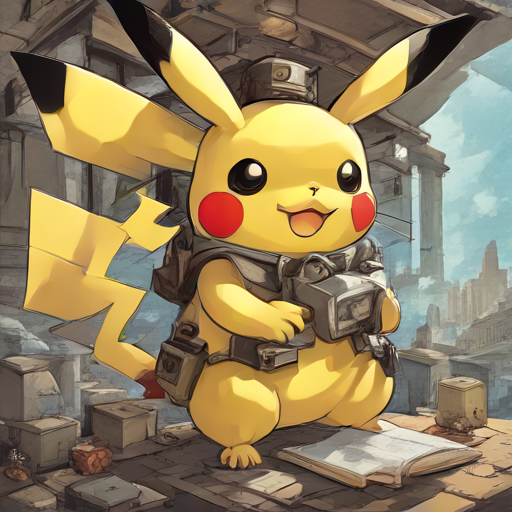

In a world of vibrant hues and green,
  A tiny creature stands out, so bright and keen.

With fur like cotton candy and eyes like stars,
Pikachu dances through life, without any scars.

A loyal friend, always by your side,
Through battles fierce and adventures wide.

With lightning-fast speed and a heart so pure,
Pikachu's spirit will never endure.

In every pixel, in every frame,
This little Pokémon will forever remain.

A symbol of hope, courage, and love,
Pikachu's legacy will never die.

So let us cherish this magical being,
For in its presence, our hearts will always be singing.




In [56]:
# Modify this prompt to generate different outputs
prompt = "Write a short poem about Pikachu with a picture."


response = openai.chat.completions.create(
    model=DEFAULT_LLM,
    messages=[{"role": "user", "content": prompt}],
    temperature=DEFAULT_TEMPERATURE,
    max_tokens=DEFAULT_MAX_TOKENS,
    top_p=DEFAULT_TOP_P,
    stream=False,
    extra_body={"system_message": SYSTEM_MESSAGE},
)
display_content(response.messages[1]["content"])

## Completion

[OpenAI API Reference](https://platform.openai.com/docs/api-reference/completions/create)


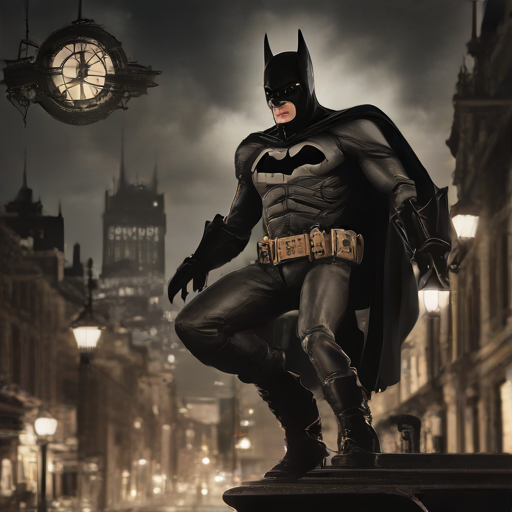

In the shadows where night falls,
Batman takes flight, his cape billows in the wind.
With each swift movement, he soars through the air,
A symbol of justice, his heart filled with fire.

  His eyes gleam like stars in the dark,
As he fights for truth, he leaves no stone unturned.
In the city's streets, he vanquishes evil,
A hero for the people, their protector.

  His mask conceals his true identity,
But his courage shines through in every stride.
He's Batman, the Dark Knight's son,
A symbol of hope in a world gone wrong.

  In the night's embrace, he stands tall,
A beacon of light in a sea of shadows.
For justice will prevail, he vows without fail,
And Gotham will be safe once more, thanks to Batman.

  [Image: A silhouette of Batman standing tall against a city skyline at night, his cape billowing in the wind.]

---

In this response, I've created a short poem about Batman that captures his heroic spirit and determination to fight for justice in Gotham City. The accompanying image sh

In [54]:
# Modify this prompt to generate different outputs
prompt = "Write a short poem about batman with an accompanying image."

completion = openai.completions.create(
    model=DEFAULT_LLM,
    prompt=prompt,
    temperature=DEFAULT_TEMPERATURE,
    max_tokens=DEFAULT_MAX_TOKENS,
    top_p=DEFAULT_TOP_P,
    n=1,
    stream=False,
    extra_body={"system_message": SYSTEM_MESSAGE},
)
display_content(completion.choices[0].text)

## Cloning Text to Speech

Any `wav` file in the `voices` directory can be used as a voice.


In [36]:
prompt = "Write a short poem about Taco Bell's Doritos Locos Tacos."
response = requests.post(
    f"{EZLOCALAI_SERVER}/v1/audio/generation",
    headers=HEADERS,
    json={
        "text": prompt,
        "voice": "DukeNukem",
        "language": "en",
    },
)
audio_response = response.json()
display_content(audio_response["data"])

UklGRkZmAwBXQVZFZm10IBAAAAABAAEAwF0AAIC7AAACABAATElTVBoAAABJTkZPSVNGVA4AAABMYXZmNTguNzYuMTAwAGRhdGEAZgMA4f/T/9z/6P/q//D//v/7/+7/8v/w//P/+v/8/wUA/P/4/wAA+//3/+v/8v/w/+j/7f/o/+j/5P/q/+v/3f/U/9H/xP+8/8j/yv/A/6//rP+j/53/nf+l/6D/qP+y/7j/vv/A/9H/yf/I/8H/xv/P/9X/1f/f/+n/5v/y//P/8v/0/wEADAAMABUAJAAkAB8AKwAxADIAMgA0AC0AKAA8ADYAPgA8AD0ARwBVAFgAYABfAGMAawB2AHgAewB8AIEAhACRAJQAkgCKAI8AlACSAJEAmACdAKYAsACvAKsAuwC9ALEAqwCiAJsAlACLAI0AiwCbAKQAmgCYAIcAiwCDAIkAjQCLAJAAjQCIAIsAkwCRAIkAjACDAH8AfwCIAIUAfQB7AG4AcwB7AIAAfgB8AHYAcwBxAG8AcAB0AGQAZgBtAGUAZgB1AHYAewCAAIUAiQCPAI8AhgCDAI8AhgB9AH0AeQCMAIMAiACeAJoAoQCrAKMAnQCiAKYApwCuAKsAuAC3ALsAwAC+AL4AtwC0ALAAqgCuAKsAqwCyAKcAuAC0ALMArgC5AKMAnwCPAIoAjQB+AHQAawByAGwAfQBuAHYAcwBtAG0AcABwAGgAZABcAFcAVABsAHwAcgB4AIgAlgCqALYAxwDNAN4A8AAIARIBLQE5AUUBTAFZAWcBbQF7AXABawFXAVMBPAE7ATIBOgFJAVABagF4AWABYQFcATQBLQFHAVABWwFrAV8BQgESAegAuAB6ACwA9/++/5z/cf9p/2T/Yv9i/2b/Yf9a/0v/PP9H/0n/Sf9J/07/Xv+C/4//nf+t/7z/0//X/83/0//P/9H/z//H/8r/yf/L/7n/r/+b/5P/cf9g/0b/G//1/tD+t/6U/nX+X/5N/iH+

## Text to Speech


In [37]:
# We will use the audio response from the previous cell to transcribe it.
transcription = requests.post(
    f"{EZLOCALAI_SERVER}/v1/audio/transcriptions",
    json={
        "file": audio_response["data"],
        "audio_format": "wav",
        "model": "base",
    },
    headers=HEADERS,
)


print(transcription.json())

{'data': " Write a short poem about Taco Bell's Doritos Locos Tacos."}


## Voice Completion Example


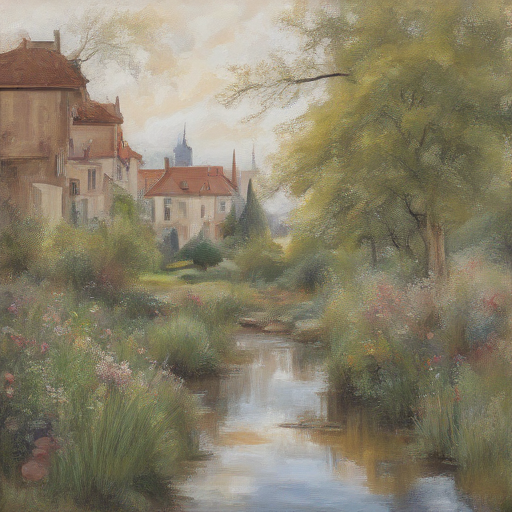

In a world where flavors collide,
A Taco Bell Locos Taco takes pride,
With spices that dance on your tongue,
A symphony of heat that's never done.

  The tortilla's soft embrace,
Filled with meat that's cooked just right,
A medley of flavors that ignite,
A taste that's pure delight.

  The salsa's tangy kiss,
A burst of heat that's hard to resist,
The guacamole's creamy delight,
A perfect complement, just right.

  The cheese's gooey embrace,
A layer of flavor that's hard to resist,
The sour cream's cool touch,
A balance that's hard to match.

  The Locos Taco's a feast for the senses,
A culinary adventure that never ends,
A taste that's unforgettable,
A flavor that's truly remarkable.

  So come on down to Taco Bell,
And indulge in Locos Taco's spell,
A taste that's out of this world,
A flavor that's truly unfathomable.

  In this world where flavors collide,
A Taco Bell Locos Taco takes pride,
A symphony of heat that's never done,
A taste that's pure delight.
http://localhost:8091/ou

In [38]:
# We will use the audio response from a couple of cells back.
completion = openai.completions.create(
    model=DEFAULT_LLM,
    prompt=audio_response["data"],
    temperature=DEFAULT_TEMPERATURE,
    max_tokens=DEFAULT_MAX_TOKENS,
    top_p=DEFAULT_TOP_P,
    n=1,
    stream=False,
    extra_body={
        "system_message": SYSTEM_MESSAGE,
        "audio_format": "wav",
        "voice": "DukeNukem",
    },
)

response_text = completion.choices[0].text
display_content(response_text)